remember: this is a file for local, not colab, so the path is different

In [ ]:
!pip install kaggle torchtext

# Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [ ]:
# from google.colab import files
# ## 上传创建好的API Token的json文件
# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Kaggle 数据集

In [ ]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis
!unzip imdb-movie-ratings-sentiment-analysis.zip

In [3]:
import pandas as pd 
import os
## data with imdb-movie
## https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis
basepath = ""
movie_path = basepath + "movie.csv"
movie_df = pd.read_csv(movie_path)
movie_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## D2L IMDB 数据集

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

In [ ]:
!tar xf aclImdb_v1.tar.gz

## 处理

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
#划分数据集
movie_train, movie_test = train_test_split(movie_df, test_size=0.5, random_state=0)
print(len(movie_train), len(movie_test))
movie_train.columns = ['sentence','label']
movie_train.head()

20000 20000


,sentence,label
12812,Watch this movie .....only to truly appreciate...,0
33842,The highlight of this movie for me was without...,0
27705,"And again, I find myself in the minority.<br /...",0
37740,I will not comment on the story as such. I agr...,1
20217,"After a meteorite lands in ""Boston"" (really so...",0


In [5]:
data_dir = "aclImdb"
def read_imdb(data_dir, train):
    """读取IMDb评论数据集文本序列和标签"""
    """分别读取训练集与测试集"""
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if train else 'test', label)
        print(folder_name)
        for file in os.listdir(folder_name):
          with open(os.path.join(folder_name, file), 'rb') as f:
              review = f.read().decode('utf-8').replace('\n', '')
              data.append(review)
              labels.append(1 if label == 'pos' else 0)
    return data, labels
imdb_open = read_imdb(data_dir, True)
imdb_train = pd.DataFrame([imdb_open[0], imdb_open[1]]).T
imdb_train.columns = ['sentence','label']
# 0 data 1 labels
# 整合并且打印前五条
print(imdb_train.head())

aclImdb/train/pos
aclImdb/train/neg
                                            sentence label
0  Deliverance is a stunning thriller, every bit ...     1
1  MPAA:Rated R for Violence,Language,Nudity and ...     1
2  One of the best of the Fred Astaire and Giner ...     1
3  The only complaint I have about this adaptatio...     1
4  Playing out as a sort of pre runner to The Gre...     1


In [7]:
#使用类的方式避免重复运算
class Vocab:
    #min_freq：把出现次数少于min_freq的低频率词元视为相同的未知词元视为'<unk>'
    def __init__(self, tokens=[], min_freq=0):
        # 展开多维的token列表
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # 计算token中对应数据的出现次数，从大到小
        counter = collections.Counter(tokens)
        self.freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The list of unique tokens
        self.index_to_token = sorted([token for token, freq in self.freqs 
                                      if freq >= min_freq]) + ['<unk>']
        self.token_to_index = {token: idx
                             for idx, token in enumerate(self.index_to_token)}

    def __len__(self):
        return len(self.index_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            # if not exist '<unk>'
            return self.token_to_index.get(tokens, self.token_to_index['<unk>'])
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if isinstance(indices, list):
            return [self.index_to_token[int(index)] for index in indices]
        return self.index_to_token[indices]

In [8]:
import string
import collections

def token_nize(sentence_list):
  wordss = []
  for s in sentence_list:
    words = s.split(" ")
    words = [w.strip(string.punctuation) for w in words]
    wordss.append(words)
  return wordss

## 去除标点符号

train_data = pd.concat([movie_train, imdb_train])
print(len(train_data), train_data.head())
train_tokens = token_nize(train_data["sentence"])

#这个词汇表包含了所有在tokens中出现的单词（word）
#但是出现次数少于5次的单词将被视为低频词（infrequent words）
#并被替换为一个特殊的标记（token）'<unk>'
#用于在文本序列长度不一致时进行填充。这个词汇表可以被用于将文本序列转换为数字序列，方便模型进行处理。
vocab = Vocab(train_tokens, min_freq=5)

45000                                                 sentence label
12812  Watch this movie .....only to truly appreciate...     0
33842  The highlight of this movie for me was without...     0
27705  And again, I find myself in the minority.<br /...     0
37740  I will not comment on the story as such. I agr...     1
20217  After a meteorite lands in "Boston" (really so...     0


In [9]:
import matplotlib.pyplot as plt

(array([  997.,  4273., 12240.,  8668.,  5116.,  3338.,  2530.,  1801.,
         1359.,  1032.,   794.,   644.,   455.,   382.,   299.,   243.,
          197.,   156.,   125.]),
 array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
        650, 700, 750, 800, 850, 900, 950]),
 <BarContainer object of 19 artists>)

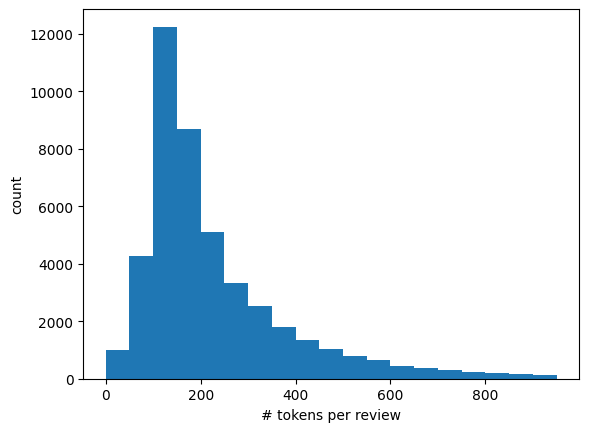

In [10]:
plt.xlabel('# tokens per review')
plt.ylabel('count')
plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [11]:
import torch
num_steps = 500  # 序列长度

def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad


train_features = torch.tensor([truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

torch.Size([45000, 500])


In [12]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器。"""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [13]:
def load_data(batch_size, num_steps=500):
    imdb_data_dir = "aclImdb"
    imdb_train_data = read_imdb(imdb_data_dir, True)
    imdb_train = pd.DataFrame([imdb_train_data[0], imdb_train_data[1]]).T
    imdb_train.columns = ['sentence','label']
    imdb_test_data = read_imdb(imdb_data_dir, False)
    imdb_test = pd.DataFrame([imdb_test_data[0], imdb_test_data[1]]).T
    imdb_test.columns = ['sentence','label']
    
    movie_train, movie_test = train_test_split(movie_df, test_size=0.5, random_state=0)
    movie_train.columns = ['sentence','label']
    movie_test.columns = ['sentence','label']
    
    train_data = pd.concat([movie_train, imdb_train])
    test_data = pd.concat([movie_test, imdb_test])
    train_data['label'] = train_data['label'].astype(int)
    test_data['label'] = test_data['label'].astype(int)
    
    train_tokens = token_nize(train_data["sentence"])
    test_tokens = token_nize(test_data["sentence"])
    vocab = Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = load_array((train_features, torch.tensor(train_data["label"].values)), batch_size)
    test_iter = load_array((test_features, torch.tensor(test_data["label"].values)), batch_size, is_train=False)
    return train_iter, test_iter, vocab

## 加载数据

In [14]:
from torch import nn
batch_size = 64
train_iter, test_iter, vocab = load_data(batch_size)

aclImdb/train/pos
aclImdb/train/neg
aclImdb/test/pos
aclImdb/test/neg
